In [20]:
# libraries
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [18, 12]

# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.metrics

# Hyper-parameters

In [21]:
hyper_params = {
    'valid_size': 0.2,
    'batch_size': 64,
    'num_workers': 0,
    'num_epochs': 10,
    'lr': 0.001,
    'step_size': 10,
    'gamma': 0.2,
    'num_iterations': 10,
}

downward_params = {
    'in_channels': 3,
    'emb_sizes': [8, 16, 32, 64, 128],
    'kernel_sizes': [3, 3, 3 ,3 ,3],
    'paddings': [1, 1, 1, 1, 1],
    'batch_norm_first': True,
}

upward_params = {
    'in_channels': [128, 256, 128, 64, 32],
    'emb_sizes': [256, 128, 64, 32, 16],
    'out_channels': [128, 64, 32, 16, 8],
    'kernel_sizes': [3, 3, 3, 3, 3],
    'paddings': [1, 1, 1, 1, 1],
    'batch_norm_first': True,
    'bilinear': False,
}

output_params = {
    'in_channels': 16,
    'n_classes': 3,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
STEPS = 20

work_dir = '/global/u2/g/geshi/OxfordIIITPet_Segmentation'
data_dir = '/global/u2/g/geshi/OxfordIIITPet_Segmentation/data'
pretrained_model_path = '/global/u2/g/geshi/OxfordIIITPet_Segmentation/exp/05-02-2023-03:37:44.pt'

# Create model and instance 

In [22]:
import sys
import os
sys.path.append(os.path.join(work_dir, 'src'))

from models import Unet
from input_pipeline import get_datasets

In [23]:
dataloaders, dataset_sizes, classes = get_datasets('OxfordIIITPet', os.path.join(os.getcwd(), data_dir), hyper_params)

In [24]:
criterion = torch.nn.CrossEntropyLoss()

model = Unet(downward_params, upward_params, output_params)
model = model.to(device)
model.eval()
# stores the initial point in parameter space
model_initial = copy.deepcopy(model)
# load the final pretrained model
checkpoint = torch.load(pretrained_model_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model_final = copy.deepcopy(model)

# Linear Interpolations of Loss between Two Points

In [25]:
def eval_loss(model_initial, model_final, data_loader, device, criterion, STEPS, deepcopy_model=True):
    model_initial.eval()
    model_final.eval()
    
    count = 0
    loss_data = 0.
    with torch.no_grad():
        for count, batch in enumerate(data_loader, 0):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            batch_size = x.shape[0]
            
            metric = loss_landscapes.metrics.Loss(criterion, x, y)
            batch_loss_data = loss_landscapes.linear_interpolation(model_initial, model_final, metric, STEPS, deepcopy_model=deepcopy_model)           
            
            loss_data = (count)/(count+batch_size)*loss_data + batch_size/(count+batch_size)*batch_loss_data
            count+=batch_size
    return loss_data

In [26]:
loss_data = eval_loss(model_final, model_initial, dataloaders['train'], device, criterion, STEPS, deepcopy_model=True)

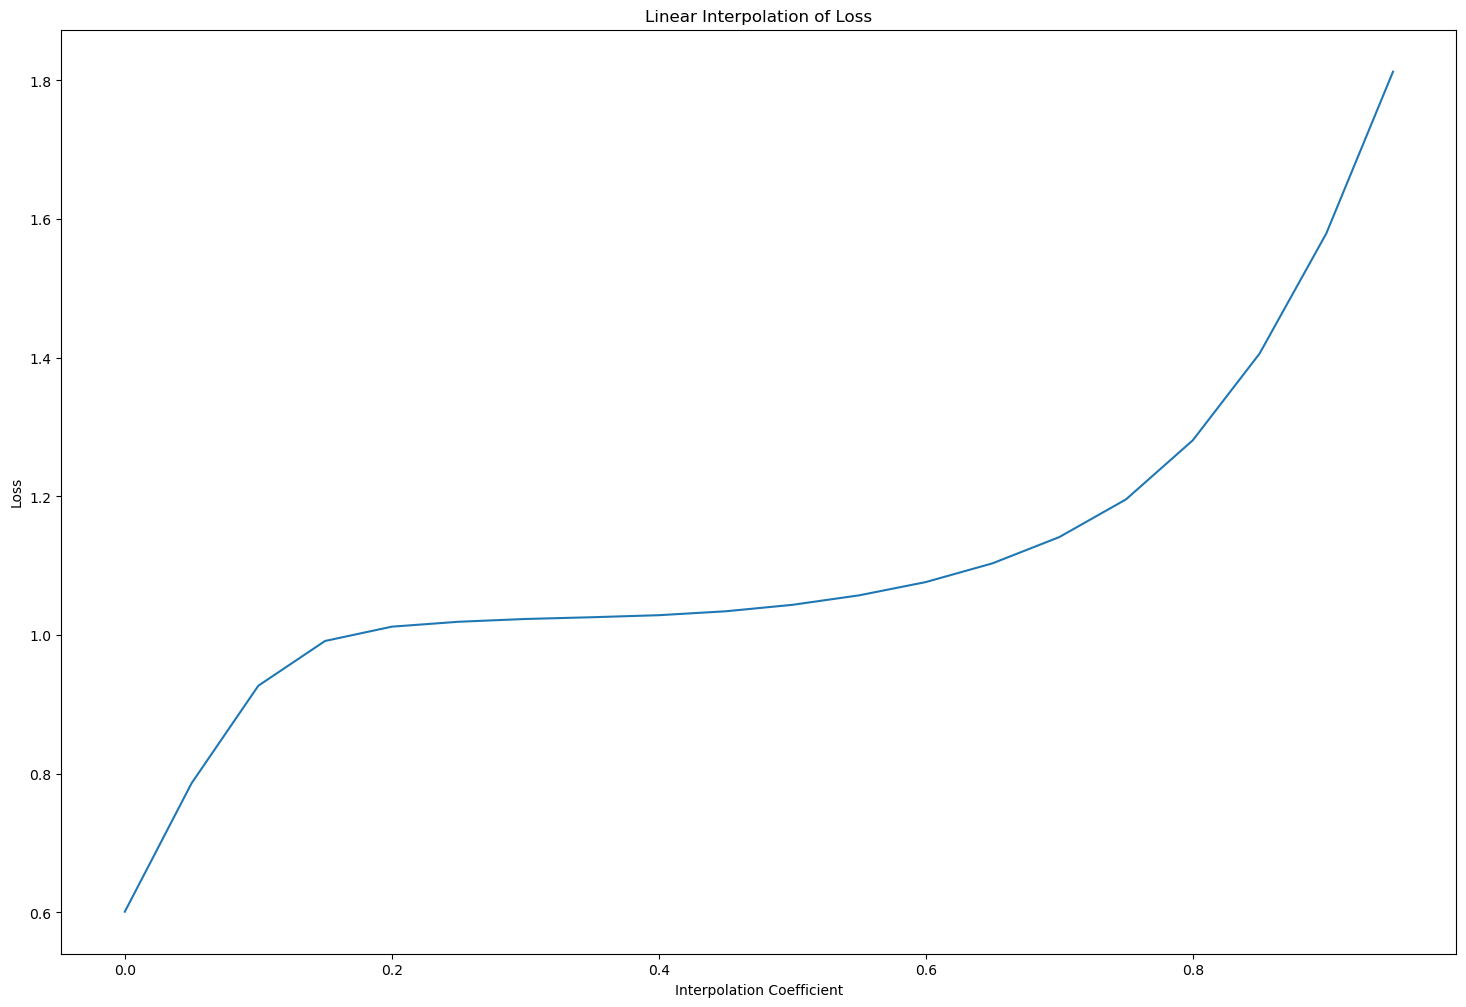

In [27]:
plt.plot([1/STEPS * i for i in range(STEPS)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

# Planar Approximations of Loss Around a Point

In [9]:
# loss_data_fin = loss_landscapes.random_plane_rmbn2(model_final, metric, 0.1, STEPS, normalization='filter', deepcopy_model=True)

In [10]:
def eval_loss_fin(model_final, data_loader, device, criterion, distance, STEPS, normalization='filter', deepcopy_model=True):
    model_final.eval()
    
    count = 0
    loss_data_fin = 0.
    with torch.no_grad():
        for count, batch in enumerate(data_loader, 0):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            batch_size = x.shape[0]
            
            metric = loss_landscapes.metrics.Loss(criterion, x, y)
            batch_loss_data = loss_landscapes.random_plane(model_final, metric, distance, STEPS, normalization=normalization, deepcopy_model=deepcopy_model)           
            
            loss_data_fin = (count)/(count+batch_size)*loss_data_fin + batch_size/(count+batch_size)*batch_loss_data
            count+=batch_size
    return loss_data_fin

In [11]:
loss_data_fin = eval_loss_fin(model_final, dataloaders['train'], device, criterion, 0.5, STEPS, normalization='filter', deepcopy_model=True)

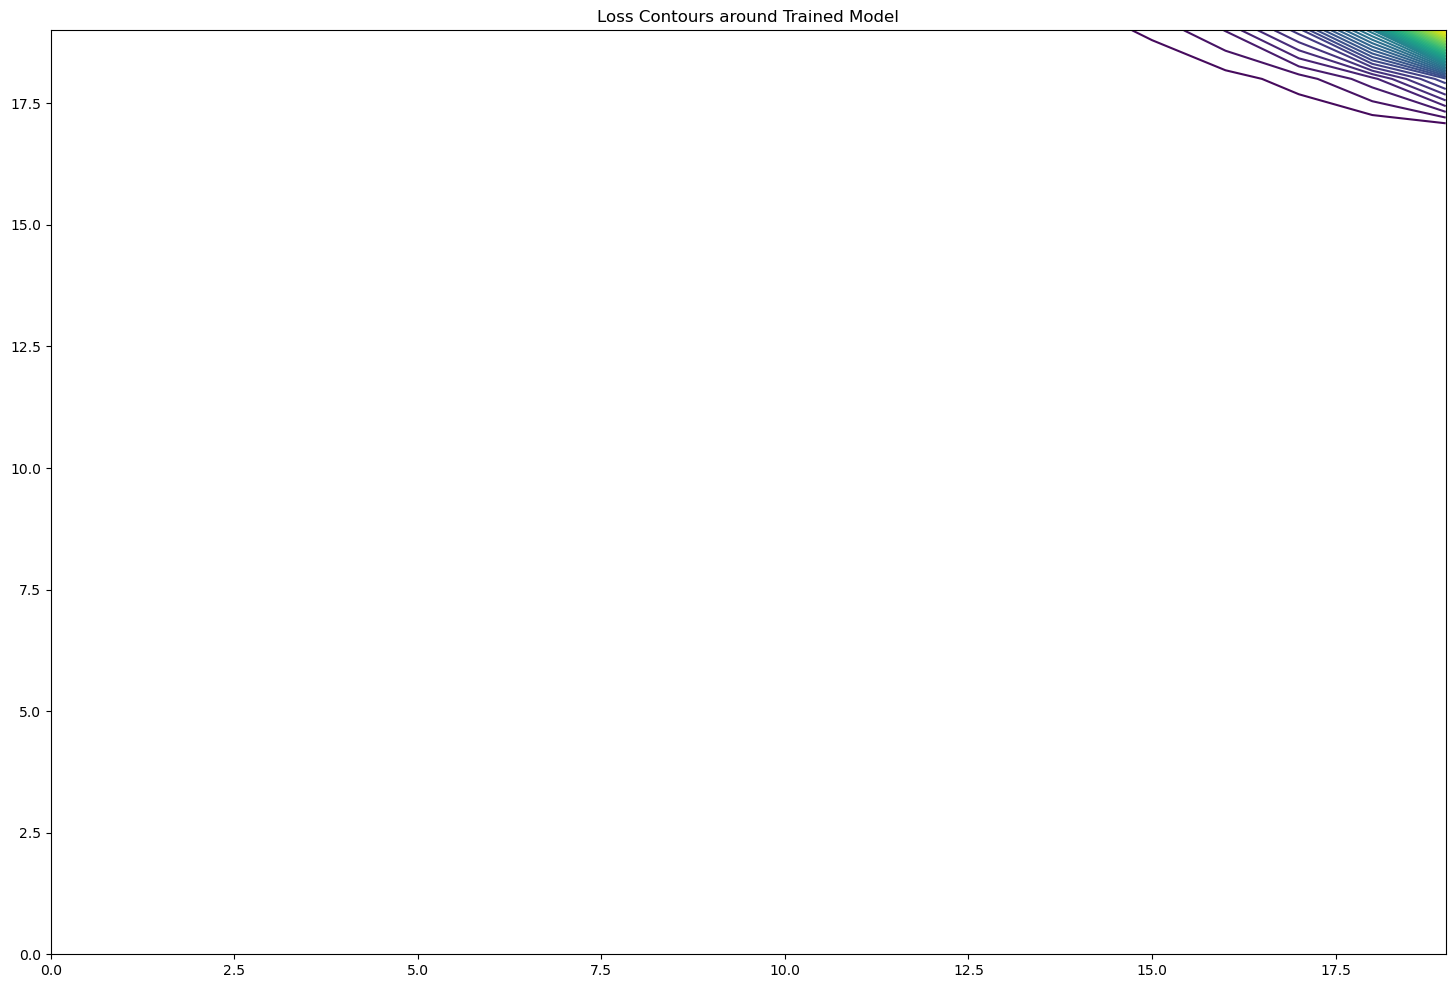

In [12]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

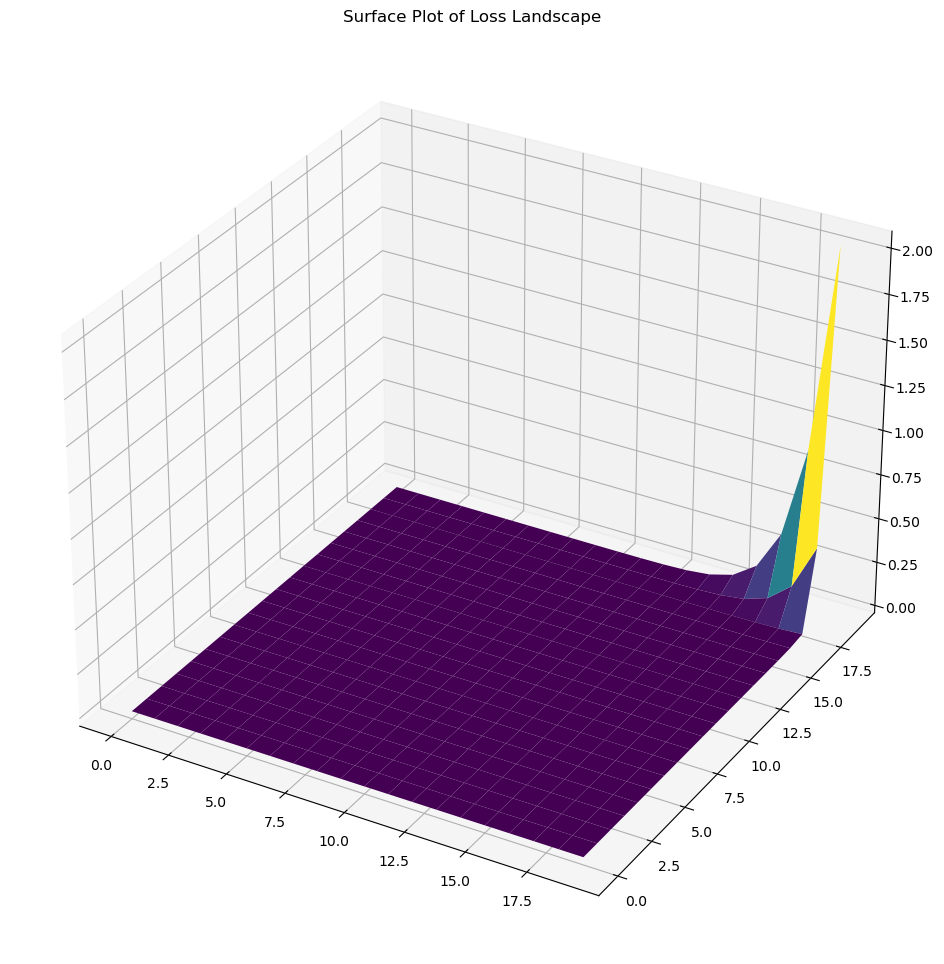

In [13]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [14]:
loss_data_fin.shape

(20, 20)

In [15]:
loss_data_fin

array([[1.03928957e+00, 1.03956163e+00, 1.03978056e+00, 1.03990980e+00,
        1.03988617e+00, 1.03979676e+00, 1.03968223e+00, 1.03962810e+00,
        1.03957186e+00, 1.03955163e+00, 1.03960430e+00, 1.03967385e+00,
        1.03970735e+00, 1.03969773e+00, 1.03964759e+00, 1.03955969e+00,
        1.03948297e+00, 1.03936408e+00, 1.03923158e+00, 1.03908524e+00],
       [1.03803390e+00, 1.03825266e+00, 1.03834657e+00, 1.03833126e+00,
        1.03831925e+00, 1.03832463e+00, 1.03831125e+00, 1.03829598e+00,
        1.03835489e+00, 1.03839355e+00, 1.03844170e+00, 1.03850174e+00,
        1.03848055e+00, 1.03829534e+00, 1.03808410e+00, 1.03791895e+00,
        1.03763972e+00, 1.03730519e+00, 1.03696981e+00, 1.03673468e+00],
       [1.03635395e+00, 1.03643544e+00, 1.03650031e+00, 1.03659796e+00,
        1.03669897e+00, 1.03679286e+00, 1.03687814e+00, 1.03697379e+00,
        1.03701330e+00, 1.03699487e+00, 1.03694658e+00, 1.03682668e+00,
        1.03648124e+00, 1.03605710e+00, 1.03554695e+00, 1.0350

In [16]:
second_dict = dict(model.state_dict())

In [17]:
first_dict = dict(model.named_parameters())

In [18]:
diff_dict = { key : second_dict[key] for key in set(second_dict) - set(first_dict) }

In [19]:
for name, param in diff_dict.items():
    print(name, param.shape)

encoder.blocks.0.conv_proj.conv_proj.4.running_var torch.Size([8])
decoder.blocks.2.conv_proj.conv_proj.4.running_var torch.Size([64])
decoder.blocks.2.conv_proj.conv_proj.1.running_var torch.Size([64])
classifier.classifier.1.num_batches_tracked torch.Size([])
decoder.blocks.0.conv_proj.conv_proj.4.running_mean torch.Size([256])
encoder.blocks.4.conv_proj.conv_proj.4.running_var torch.Size([128])
decoder.blocks.3.conv_proj.conv_proj.4.running_mean torch.Size([32])
encoder.blocks.1.conv_proj.conv_proj.1.num_batches_tracked torch.Size([])
decoder.blocks.4.conv_proj.conv_proj.4.num_batches_tracked torch.Size([])
decoder.blocks.2.conv_proj.conv_proj.1.running_mean torch.Size([64])
encoder.blocks.0.conv_proj.conv_proj.4.num_batches_tracked torch.Size([])
encoder.blocks.2.conv_proj.conv_proj.1.num_batches_tracked torch.Size([])
encoder.blocks.4.conv_proj.conv_proj.1.running_mean torch.Size([128])
decoder.blocks.3.conv_proj.conv_proj.1.running_mean torch.Size([32])
encoder.blocks.4.conv_proj